In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import math
import xgboost
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

from google.colab import files
from datetime import date

In [ ]:
uploaded = files.upload()
filename = next(iter(uploaded))
print("File: ", filename)

Saving Dataset.csv to Dataset.csv
File:  Dataset.csv


In [ ]:
df = pd.read_csv(filename)

print("Loaded Shape:", df.shape, end = '\n\n')

print('Data types:\n', df.dtypes, end = '\n\n', sep = '')

print("\nStructure:")
display(df.head())

print("\n\nBasic numerical summary (count, mean, std, min, Q1, Q2, Q3, max):")
display(df[['price']].describe().T)

Loaded Shape: (13320, 9)

Data types:
area_type        object
availability     object
location         object
size             object
society          object
total_sqft       object
bath            float64
balcony         float64
price           float64
dtype: object


Structure:


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00




Basic numerical summary (count, mean, std, min, Q1, Q2, Q3, max):


,count,mean,std,min,25%,50%,75%,max
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


In [ ]:

df['total_sqft'] = df['total_sqft'].apply(lambda x: float(x[:x.index('S')])*10.76391041671 if 'Sq. Meter' in str(x) else x)
df['total_sqft'] = df['total_sqft'].apply(lambda x: float(x[:x.index('S')])*10 if 'Sq. Yards' in str(x) else x)
df['total_sqft'] = df['total_sqft'].apply(lambda x: x[:next((i for i, c in enumerate(x) if c.isalpha()))] if any(c.isalpha() for c in str(x)) else x)
df['total_sqft'] = df['total_sqft'].apply(lambda x: (float(x.split(' - ')[0]) + float(x.split(' - ')[1])) / 2 if ' - ' in str(x) else float(x))

df['size'] = df['size'].astype(str)
df['size'] = df['size'].apply(lambda x: int(x[:2]) if len(x) > 1 and x[0].isnumeric() and x[1].isnumeric() and x != 'nan' else
 (int(x[0]) if x != 'nan' and len(x) > 0 and x[0].isnumeric() else 1))
df['size'] = df['size'].astype(int)

df['bath'] = df['bath'].replace('', np.nan)
mask = df['bath'].isna()
df.loc[mask, 'bath'] = np.where(df.loc[mask, 'size'] > 1, df.loc[mask, 'size'] - 1, df.loc[mask, 'size'])
df['bath'] = df['bath'].astype(int)

df['balcony'] = df['balcony'].replace('', np.nan)
df['balcony'] = df['balcony'].fillna(0)
df['balcony'] = df['balcony'].astype(int)

month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
def date_parser(s):
  s = str(s).lower().strip()
  if s == 'ready to move':
    return np.nan
  try:
    day, month_str = s.split('-')
    month_num = month_map.get(month_str[:3], None)
    if month_num is not None:
      return date(2020, int(month_num), int(day))
    else:
        return np.nan
  except (ValueError, IndexError):
    return np.nan
df['availability'] = df['availability'].apply(date_parser)
mask2 = df['availability'].notna()
early = df.loc[mask2, 'availability'].min()
print(f"\nEarliest date found: {early.strftime('%d-%b-%Y')}")
df['availability'] = (df.loc[mask2, 'availability'] - early).apply(lambda x: x.days).astype('float')
df['availability'] = df['availability'].fillna(0)
df['availability'] = df['availability'].astype(int)
month_map['ready to move'] = 0


Earliest date found: 16-Jan-2020


In [ ]:
for i in df.columns:
  if df[i].dtype == 'object':
    df[i] = df[i].fillna('other')

area_map = {'Super built-up  Area': 3, 'Built-up  Area': 2, 'Plot  Area': 4, "Carpet  Area": 1}
df['area_type'] = df['area_type'].replace(area_map)
df['area_type'] = df['area_type'].astype(int)

In [ ]:
display(df.head())

print('\n\nData types:\n', df.dtypes, end = '\n\n', sep = '')

display(df[['area_type', 'availability', 'size', 'total_sqft', 'bath', 'balcony', 'price']].describe())

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,3,338,Electronic City Phase II,2,Coomee,1056.0,2,1,39.07
1,4,0,Chikka Tirupathi,4,Theanmp,2600.0,5,3,120.00
2,2,0,Uttarahalli,3,other,1440.0,2,3,62.00
3,3,0,Lingadheeranahalli,3,Soiewre,1521.0,3,1,95.00
4,3,0,Kothanur,2,other,1200.0,2,1,51.00




Data types:
area_type         int64
availability      int64
location         object
size              int64
society          object
total_sqft      float64
bath              int64
balcony           int64
price           float64
dtype: object



,area_type,availability,size,total_sqft,bath,balcony,price
count,13320.000000,13320.000000,13320.000000,13320.000000,13320.000000,13320.000000,13320.000000
mean,2.957432,39.566141,2.801577,1568.191834,2.689114,1.511937,112.565627
std,0.598247,92.531021,1.295703,1312.147657,1.340225,0.864240,148.971674
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,8.000000
25%,3.000000,0.000000,2.000000,1100.000000,2.000000,1.000000,50.000000
50%,3.000000,0.000000,3.000000,1276.000000,2.000000,2.000000,72.000000
75%,3.000000,0.000000,3.000000,1680.000000,3.000000,2.000000,120.000000
max,4.000000,341.000000,43.000000,52272.000000,40.000000,3.000000,3600.000000


In [ ]:
print(df)

loc_map = dict()
kv = 0
enc = []
for loc in df['location']:
  if loc not in loc_map:
    kv += 1
    loc_map[loc] = kv
    enc.append(kv)
  else:
    enc.append(loc_map[loc])
df['location'] = enc
df['location'] = df['location'].astype(int)

soc_map = dict()
kv = 0
enc = []
for soc in df['society']:
  if soc not in soc_map:
    kv += 1
    soc_map[soc] = kv
    enc.append(kv)
  else:
    enc.append(soc_map[soc])
df['society'] = enc
df['society'] = df['society'].astype(int)

       area_type  availability                  location  size  society  \
0              3           338  Electronic City Phase II     2  Coomee    
1              4             0          Chikka Tirupathi     4  Theanmp   
2              2             0               Uttarahalli     3    other   
3              3             0        Lingadheeranahalli     3  Soiewre   
4              3             0                  Kothanur     2    other   
...          ...           ...                       ...   ...      ...   
13315          2             0                Whitefield     5  ArsiaEx   
13316          3             0             Richards Town     4    other   
13317          2             0     Raja Rajeshwari Nagar     2  Mahla T   
13318          3           154           Padmanabhanagar     4  SollyCl   
13319          3             0              Doddathoguru     1    other   

       total_sqft  bath  balcony   price  
0          1056.0     2        1   39.07  
1          26

In [ ]:
columns = df.select_dtypes(include=np.number)
print("Columns:\n", columns, end = '\n\n\n', sep = '')

Columns:
       area_type  availability  location  size  society  total_sqft  bath  \
0              3           338         1     2        1      1056.0     2   
1              4             0         2     4        2      2600.0     5   
2              2             0         3     3        3      1440.0     2   
3              3             0         4     3        4      1521.0     3   
4              3             0         5     2        3      1200.0     2   
...          ...           ...       ...   ...      ...         ...   ...   
13315          2             0         6     5      470      3453.0     4   
13316          3             0       867     4        3      3600.0     5   
13317          2             0        16     2     1236      1141.0     2   
13318          3           154       129     4     2448      4689.0     4   
13319          3             0        38     1        3       550.0     1   

       balcony   price  
0            1   39.07  
1            3  

Columns:
        area_type  availability  location  size  society  total_sqft  bath  \
0              3           338         1     2        1      1056.0     2   
1              4             0         2     4        2      2600.0     5   
2              2             0         3     3        3      1440.0     2   
3              3             0         4     3        4      1521.0     3   
4              3             0         5     2        3      1200.0     2   
...          ...           ...       ...   ...      ...         ...   ...   
13315          2             0         6     5      470      3453.0     4   
13316          3             0       867     4        3      3600.0     5   
13317          2             0        16     2     1236      1141.0     2   
13318          3           154       129     4     2448      4689.0     4   
13319          3             0        38     1        3       550.0     1   

       balcony   price  
0            1   39.07  
1            3 

,count,mean,std,min,25%,50%,75%,max
area_type,13320.0,2.957432,0.598247,1.0,3.0,3.0,3.0,4.0
availability,13320.0,39.566141,92.531021,0.0,0.0,0.0,0.0,341.0
location,13320.0,240.045270,279.383061,1.0,31.0,137.0,349.0,1306.0
size,13320.0,2.801577,1.295703,1.0,2.0,3.0,3.0,43.0
society,13320.0,485.637988,694.282225,1.0,3.0,100.0,741.0,2689.0
total_sqft,13320.0,1568.191834,1312.147657,1.0,1100.0,1276.0,1680.0,52272.0
bath,13320.0,2.689114,1.340225,1.0,2.0,2.0,3.0,40.0
balcony,13320.0,1.511937,0.864240,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


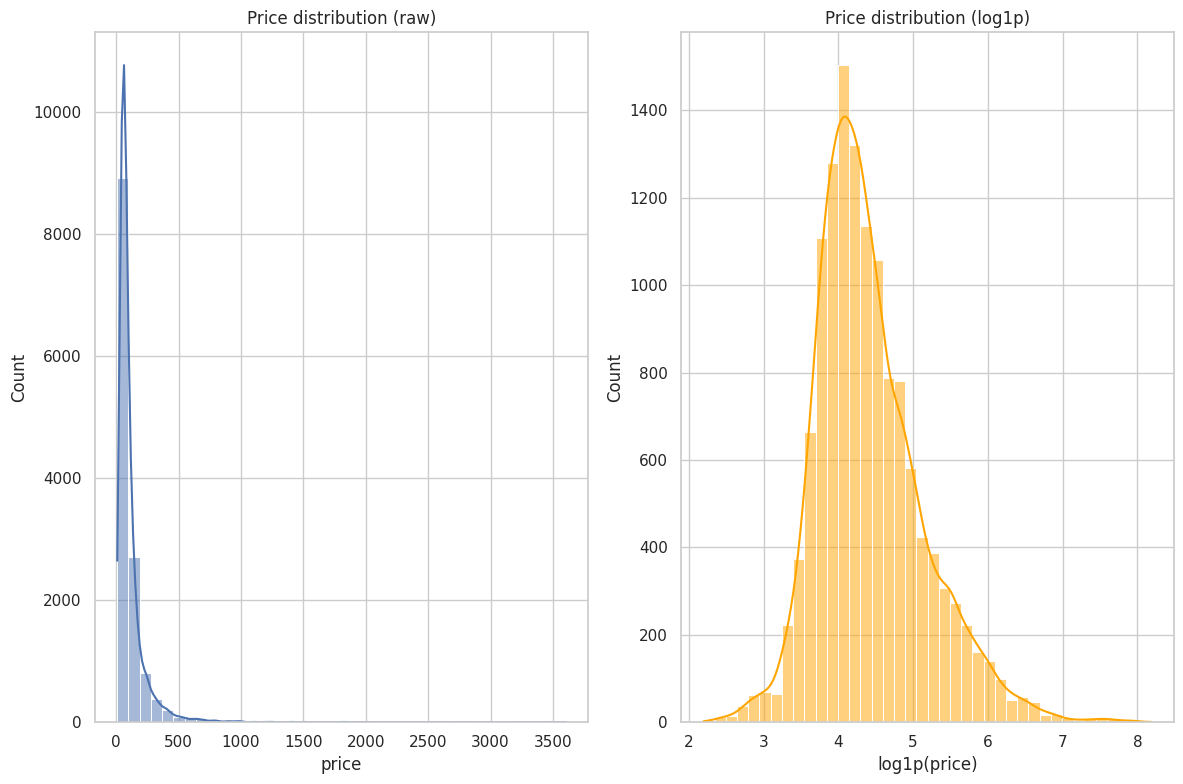

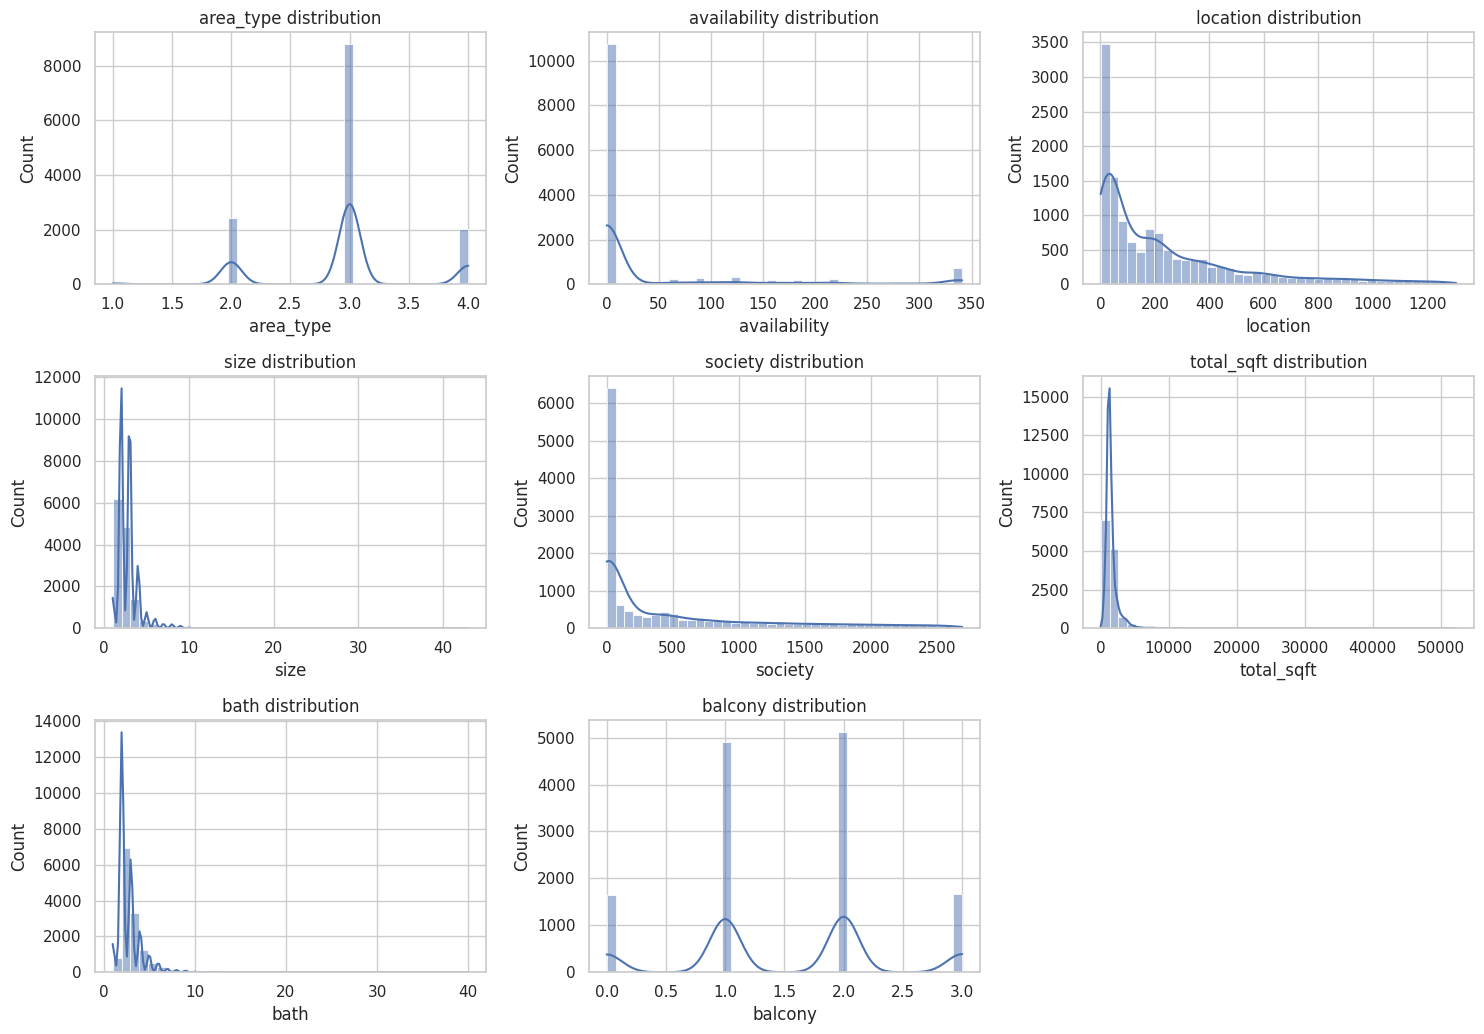

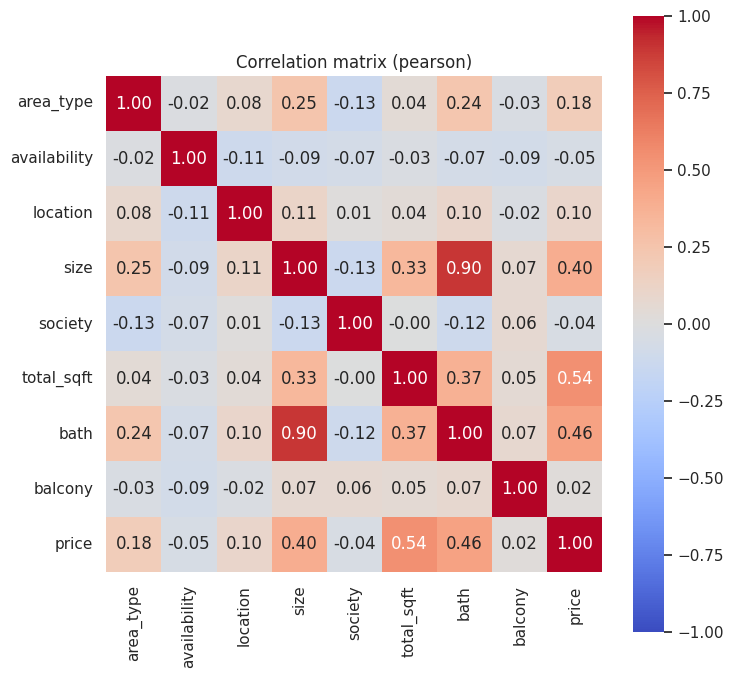

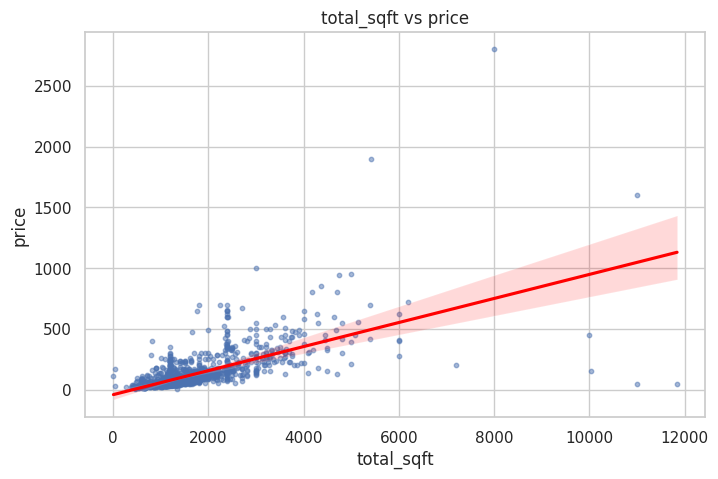

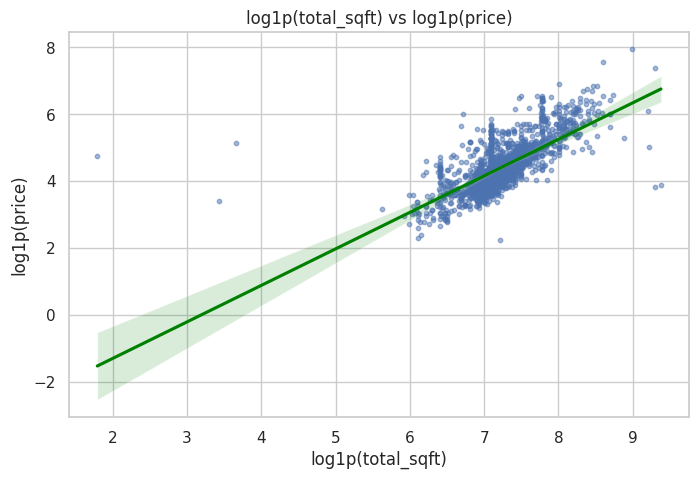

In [ ]:
cols = [c for c in columns]
print("Columns:\n", columns)
display(df[cols].describe().T)

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.histplot(df["price"].dropna(), bins=40, kde=True)
plt.title("Price distribution (raw)")
plt.xlabel("price")

plt.subplot(1,2,2)
sns.histplot(np.log1p(df["price"].dropna()), bins=40, kde=True, color="orange")
plt.title("Price distribution (log1p)")
plt.xlabel("log1p(price)")

plt.tight_layout()
plt.show()

other = [c for c in cols if c != "price"]
n = len(other)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row * 5, rows * 3.5))
for i, c in enumerate(other, 1):
  plt.subplot(rows, cols_per_row, i)
  sns.histplot(df[c].dropna(), bins=40, kde=True)
  plt.title(f"{c} distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
corr = df[cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Correlation matrix (pearson)")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(x="total_sqft", y="price", data=df.sample(min(2000, len(df)), random_state=42), scatter_kws={"s":10, "alpha":0.5}, line_kws={"color":"red"})
plt.xlabel("total_sqft")
plt.ylabel("price")
plt.title("total_sqft vs price")
plt.show()

plt.figure(figsize=(8,5))
sns.regplot(x=np.log1p(df["total_sqft"].replace(0, np.nan)).dropna().sample(min(2000, len(df)), random_state=42),
            y=np.log1p(df["price"].dropna()).sample(min(2000, len(df)), random_state=42), scatter_kws={"s":10, "alpha":0.5}, line_kws={"color":"green"})
plt.xlabel("log1p(total_sqft)")
plt.ylabel("log1p(price)")
plt.title("log1p(total_sqft) vs log1p(price)")
plt.show()

In [ ]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

print("\n\n\ndtypes:\n", df[[x for x in df]].dtypes, sep='')
print("\n\n\nNull count? \n", df[[x for x in df]].isnull().sum(), sep='')

area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64



dtypes:
area_type         int64
availability      int64
location          int64
size              int64
society           int64
total_sqft      float64
bath              int64
balcony           int64
price           float64
dtype: object



Null count? 
area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=39)
X = df[['location', 'balcony', 'availability', 'area_type', 'size', 'bath', 'total_sqft']]
y = np.log1p(df['price'])

baseline_pipe = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
y_pred_lin = cross_val_predict(baseline_pipe, X, y, cv=kf, n_jobs=-1)
rmse_scores_lin = cross_val_score(baseline_pipe, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
mae_scores_lin  = cross_val_score(baseline_pipe, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
r2_scores_lin   = cross_val_score(baseline_pipe, X, y, cv=kf, scoring='r2', n_jobs=-1)

print("Linear Regression")
print(" RMSE:", -rmse_scores_lin.mean(), "±", rmse_scores_lin.std())
print(" MAE:", -mae_scores_lin.mean(), "±", mae_scores_lin.std())
print(" R2:", r2_scores_lin.mean(), "±", r2_scores_lin.std())

baseline_pipe.fit(X, y)

rf = RandomForestRegressor(n_estimators=450, max_depth=22, random_state=39, n_jobs=-1)
y_pred_rfr = cross_val_predict(rf, X, y, cv=kf, n_jobs=-1)
rmse_scores_rfr = cross_val_score(rf, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
mae_scores_rfr  = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
r2_scores_rfr   = cross_val_score(rf, X, y, cv=kf, scoring='r2', n_jobs=-1)

print("\nRandom Forest")
print(f" RMSE: {(-rmse_scores_rfr).mean():.4f} ± {rmse_scores_rfr.std():.4f}")
print(f" MAE: {(-mae_scores_rfr).mean():.4f} ± {mae_scores_rfr.std():.4f}")
print(f" R2: {r2_scores_rfr.mean():.4f} ± {r2_scores_rfr.std():.4f}")

rf.fit(X, y)

xgb = xgboost.XGBRegressor(n_estimators=250, learning_rate=0.1, max_depth=7, min_child_weight=2, random_state=39, n_jobs=-1)
y_pred_xgb = cross_val_predict(xgb, X, y, cv=kf, n_jobs=-1)
rmse_scores_xgb = cross_val_score(xgb, X, y, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
mae_scores_xgb  = cross_val_score(xgb, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
r2_scores_xgb   = cross_val_score(xgb, X, y, cv=kf, scoring='r2', n_jobs=-1)

print("\nXGBoost")
print(f" RMSE: {(-rmse_scores_xgb).mean():.4f} ± {rmse_scores_xgb.std():.4f}")
print(f" MAE: {(-mae_scores_xgb).mean():.4f} ± {mae_scores_xgb.std():.4f}")
print(f" R2: {r2_scores_xgb.mean():.4f} ± {r2_scores_xgb.std():.4f}")

xgb.fit(X, y)

Linear Regression
 RMSE: 0.5073693687188396 ± 0.02862312072385616
 MAE: 0.36125313141203375 ± 0.0036063479944366305
 R2: 0.49193394465348206 ± 0.057898459521832146

Random Forest
 RMSE: 0.3372 ± 0.0046
 MAE: 0.2296 ± 0.0031
 R2: 0.7763 ± 0.0062

XGBoost
 RMSE: 0.3234 ± 0.0070
 MAE: 0.2235 ± 0.0032
 R2: 0.7943 ± 0.0062


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=-1, num_parallel_tree=None, ...)

**Default**

Random Forest\
 RMSE: 0.3386 ± 0.0049\
 MAE: 0.2301 ± 0.0030\
 R2: 0.7744 ± 0.0064

XGBoost\
 RMSE: 0.3252 ± 0.0065\
 MAE: 0.2263 ± 0.0030\
 R2: 0.7919 ± 0.0070

 ---

**XGB: n_estimators=700, learning_rate=0.05, max_depth=8, min_child_weight=0.5**\
**RFR: n_estimators=700, max_depth=30**

Random Forest\
 RMSE: 0.3376 ± 0.0045\
 MAE: 0.2291 ± 0.0031\
 R2: 0.7758 ± 0.0061

XGBoost\
 RMSE: 0.3269 ± 0.0106\
 MAE: 0.2213 ± 0.0047\
 R2: 0.7897 ± 0.0102

  ---

**XGB: n_estimators=900, learning_rate=0.05, max_depth=8, min_child_weight=4**\
**RFR: n_estimators=900, max_depth=32**

Random Forest\
 RMSE: 0.3375 ± 0.0045\
 MAE: 0.2292 ± 0.0031\
 R2: 0.7758 ± 0.0059

XGBoost\
 RMSE: 0.3282 ± 0.0080\
 MAE: 0.2221 ± 0.0034\
 R2: 0.7881 ± 0.0077

---

**XGB: n_estimators=200, learning_rate=0.15, max_depth=8, min_child_weight=2**\
**RFR: n_estimators=200, max_depth=30**

Random Forest\
 RMSE: 0.3378 ± 0.0046\
 MAE: 0.2296 ± 0.0030\
 R2: 0.7755 ± 0.0063

XGBoost\
 RMSE: 0.3268 ± 0.0097\
 MAE: 0.2221 ± 0.0042\
 R2: 0.7899 ± 0.0099

 ---

**XGB: n_estimators=150, learning_rate=0.2, max_depth=10, min_child_weight=2**\
**RFR: n_estimators=500, max_depth=15**

Random Forest\
 RMSE: 0.3375 ± 0.0049\
 MAE: 0.2346 ± 0.0031\
 R2: 0.7759 ± 0.0057

XGBoost\
 RMSE: 0.3361 ± 0.0099\
 MAE: 0.2246 ± 0.0041\
 R2: 0.7777 ± 0.009

---

**XGB: n_estimators=200, learning_rate=0.1, max_depth=6, min_child_weight=2**\
**RFR: n_estimators=500, max_depth=5**

Random Forest\
 RMSE: 0.3685 ± 0.0066\
 MAE: 0.2723 ± 0.0024\
 R2: 0.7329 ± 0.0058

XGBoost\
 RMSE: 0.3240 ± 0.0079\
 MAE: 0.2283 ± 0.0036\
 R2: 0.7935 ± 0.0074

---

**XGB: n_estimators=200, learning_rate=0.1, max_depth=3, min_child_weight=2**\
**RFR: n_estimators=500, max_depth=20**

Random Forest\
 RMSE: 0.3371 ± 0.0045\
 MAE: 0.2301 ± 0.0031\
 R2: 0.7764 ± 0.0060

XGBoost\
 RMSE: 0.3373 ± 0.0075\
 MAE: 0.2471 ± 0.0037\
 R2: 0.7762 ± 0.0066

---

**XGB: n_estimators=200, learning_rate=0.1, max_depth=5, min_child_weight=2**\
**RFR: n_estimators=500, max_depth=25**

Random Forest\
 RMSE: 0.3373 ± 0.0044\
 MAE: 0.2292 ± 0.0032\
 R2: 0.7762 ± 0.0059

XGBoost\
 RMSE: 0.3258 ± 0.0077\
 MAE: 0.2321 ± 0.0035\
 R2: 0.7912 ± 0.0069

---

**XGB: n_estimators=200, learning_rate=0.1, max_depth=7, min_child_weight=2**\
**RFR: n_estimators=500, max_depth=22**

Random Forest\
 RMSE: 0.3372 ± 0.0047\
 MAE: 0.2295 ± 0.0032\
 R2: 0.7763 ± 0.0062

XGBoost\
 RMSE: 0.3239 ± 0.0070\
 MAE: 0.2248 ± 0.0029\
 R2: 0.7936 ± 0.0065

---

**XGB: n_estimators=200, learning_rate=0.1, max_depth=8, min_child_weight=2**\
**RFR: n_estimators=500, max_depth=23**

Random Forest\
 RMSE: 0.3374 ± 0.0045\
 MAE: 0.2294 ± 0.0031\
 R2: 0.7760 ± 0.0058

XGBoost\
 RMSE: 0.3265 ± 0.0099\
 MAE: 0.2235 ± 0.0043\
 R2: 0.7903 ± 0.0101

---

**XGB: n_estimators=250, learning_rate=0.1, max_depth=7, min_child_weight=2**\
**RFR: n_estimators=450, max_depth=22**

Random Forest\
 RMSE: 0.3372 ± 0.0046\
 MAE: 0.2296 ± 0.0031\
 R2: 0.7763 ± 0.0062

XGBoost\
 RMSE: 0.3234 ± 0.0070\
 MAE: 0.2235 ± 0.0032\
 R2: 0.7943 ± 0.0062

---

**XGB: n_estimators=300, learning_rate=0.1, max_depth=7, min_child_weight=2**\
**RFR: n_estimators=400, max_depth=22**

Random Forest\
 RMSE: 0.3374 ± 0.0046\
 MAE: 0.2297 ± 0.0031\
 R2: 0.7761 ± 0.0061

XGBoost\
 RMSE: 0.3234 ± 0.0072\
 MAE: 0.2224 ± 0.0032\
 R2: 0.7943 ± 0.0063

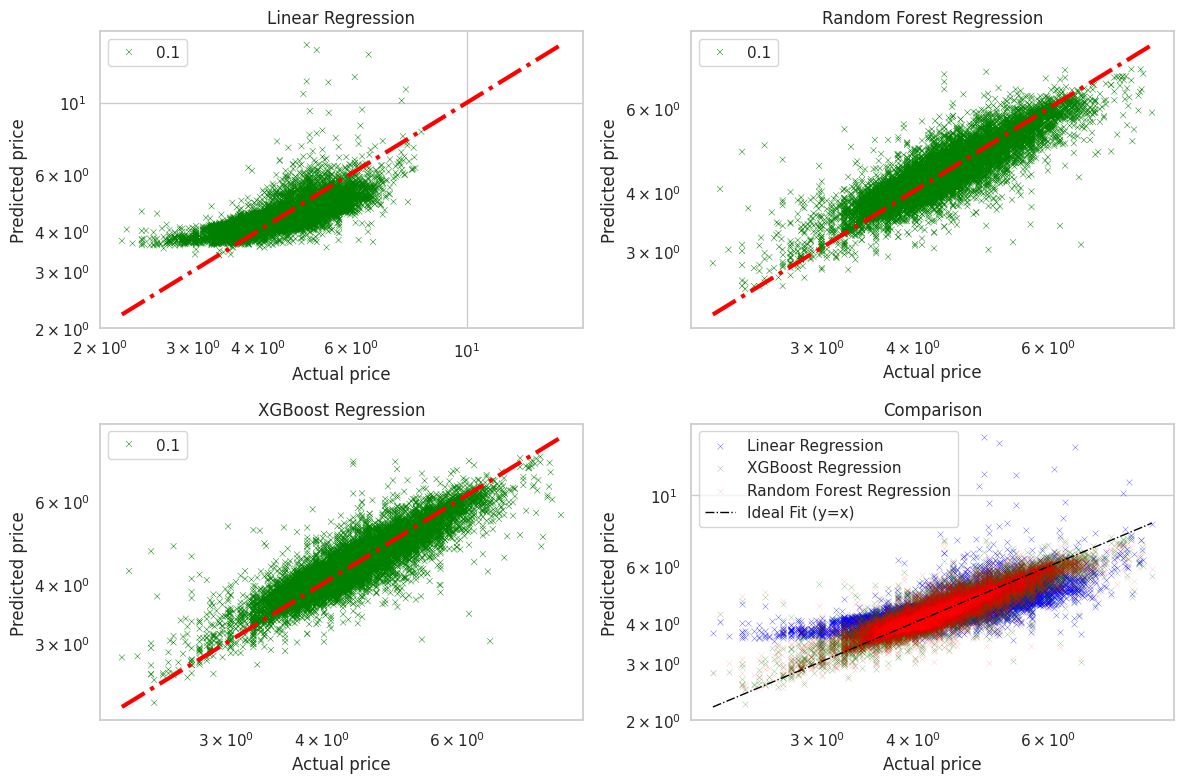

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.scatterplot(x=y, y=y_pred_lin, s=18, size=0.1, color='green', marker = 'x')
mn = min(y.min(), y_pred_lin.min())
mx = max(y.max(), y_pred_lin.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Linear Regression")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2,2,2)
sns.scatterplot(x=y, y=y_pred_rfr, s=18, size=0.1, color='green', marker = 'x')
mn = min(y.min(), y_pred_rfr.min())
mx = max(y.max(), y_pred_rfr.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Random Forest Regression")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2,2,3)
sns.scatterplot(x=y, y=y_pred_xgb, s=18, size=0.1, color='green', marker = 'x')
mn = min(y.min(), y_pred_xgb.min())
mx = max(y.max(), y_pred_xgb.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("XGBoost Regression")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2,2,4)
sns.scatterplot(x=y, y=y_pred_lin, s=18, color='blue', marker = 'x', alpha = 0.6, label='Linear Regression')
sns.scatterplot(x=y, y=y_pred_xgb, s=18, color='green', marker = 'x', alpha = 0.4, label='XGBoost Regression')
sns.scatterplot(x=y, y=y_pred_rfr, s=18, color='red', marker = 'x', alpha = 0.2, label='Random Forest Regression')
mn = min(y.min(), y_pred_xgb.min())
mx = max(y.max(), y_pred_xgb.max())
plt.plot([mn, mx], [mn, mx], color='black', linestyle='-.', linewidth=1, label='Ideal Fit (y=x)')
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.legend()
plt.title("Comparison")
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
y_true = np.expm1(y)
rfr_true = np.expm1(y_pred_rfr)
xgb_true = np.expm1(y_pred_xgb)

avg_true = (rfr_true + xgb_true) / 2
rmse_avg_true = np.sqrt(mean_squared_error(y_true, avg_true))
mae_avg_true  = mean_absolute_error(y_true, avg_true)
r2_avg_true   = r2_score(y_true, avg_true)

rmse_rfr_true = np.sqrt(mean_squared_error(y_true, rfr_true))
mae_rfr_true  = mean_absolute_error(y_true, rfr_true)
r2_rfr_true   = r2_score(y_true, rfr_true)

rmse_xgb_true = np.sqrt(mean_squared_error(y_true, xgb_true))
mae_xgb_true  = mean_absolute_error(y_true, xgb_true)
r2_xgb_true   = r2_score(y_true, xgb_true)

print("Random Forest Regression:")
print(f" RMSE: {rmse_rfr_true:.2f}")
print(f" MAE : {mae_rfr_true:.2f}")
print(f" R2  : {r2_rfr_true:.4f}")

print("\nXGBoost Regression:")
print(f" RMSE: {rmse_xgb_true:.2f}")
print(f" MAE : {mae_xgb_true:.2f}")
print(f" R2  : {r2_xgb_true:.4f}")

print("\nSimple Average Ensemble:")
print(f" RMSE: {rmse_avg_true:.2f}")
print(f" MAE : {mae_avg_true:.2f}")
print(f" R2  : {r2_avg_true:.4f}")

Random Forest Regression:
 RMSE: 98.71
 MAE : 32.27
 R2  : 0.5610

XGBoost Regression:
 RMSE: 96.95
 MAE : 31.14
 R2  : 0.5765

Simple Average Ensemble:
 RMSE: 96.35
 MAE : 31.01
 R2  : 0.5817


In [ ]:
w_opt = None
r2_avg_opt = -1
r = 0
rmse_avg_opt = None
mae_avg_opt = None
comb_wt = None

print('Weighted Average Ensemble:\n')
print('\tr2 : w\t\t\t\t'*4)
for w_ in np.linspace(0, 1, 101):
  r += 1
  w = float(f'{w_:.2f}')
  comb = w*rfr_true+(1-w)*xgb_true
  r2_w = r2_score(y_true, comb)
  print(r2_w, ':', w, end='\t\t')
  if r2_w > r2_avg_opt:
    w_opt = w
    r2_avg_opt = r2_w
    comb_wt = comb
  if r%4 == 0:
    print('\n')

print(f'\n\nw = {w_opt}; Max. R2 = {r2_avg_opt}')

rmse_avg_opt = np.sqrt(mean_squared_error(y_true, comb_wt))
mae_avg_opt  = mean_absolute_error(y_true, comb_wt)

print("\n\n\nWeighted Average Ensemble:")
print(f" RMSE: {rmse_avg_opt:.2f}")
print(f" MAE : {mae_avg_opt:.2f}")
print(f" R2  : {r2_avg_opt:.4f}")

Weighted Average Ensemble:

	r2 : w					r2 : w					r2 : w					r2 : w				
0.5764671943420918 : 0.0		0.5768258985041328 : 0.01		0.5771742247219278 : 0.02		0.5775121694494704 : 0.03		

0.577839727204793 : 0.04		0.5781569076544621 : 0.05		0.5784637114566422 : 0.06		0.5787601336658537 : 0.07		

0.579046178135249 : 0.08		0.5793218371579854 : 0.09		0.5795871090241465 : 0.1		0.5798420085359701 : 0.11		

0.5800865300867759 : 0.12		0.5803206688305755 : 0.13		0.5805444285524655 : 0.14		0.5807578066509972 : 0.15		

0.5809607932132741 : 0.16		0.5811534094325204 : 0.17		0.5813356472799597 : 0.18		0.5815075027019345 : 0.19		

0.5816689802156703 : 0.2		0.5818200733277554 : 0.21		0.5819607797044037 : 0.22		0.5820911120254695 : 0.23		

0.5822110667936675 : 0.24		0.5823206395387499 : 0.25		0.5824198292268432 : 0.26		0.5825086415890252 : 0.27		

0.5825870729801694 : 0.28		0.5826551143287986 : 0.29		0.5827127838866546 : 0.3		0.582760073222907 : 0.31		

0.5827969823269832 : 0.32		0.5828235102615141 : 0.33		

In [ ]:
stack_feats = np.vstack([xgb_true, rfr_true]).T
r2_meta = 0
y_meta = None
deg_meta = None

for deg in range(1, 15, 1):
  poly_meta_learner = Pipeline([('poly_features', PolynomialFeatures(degree=deg, include_bias=False)), ('linear_reg', LinearRegression())])
  poly_meta_learner.fit(stack_feats, y_true)
  y_tempa = poly_meta_learner.predict(stack_feats)
  r2_tempa = r2_score(y_true, y_tempa)
  print(r2_tempa, deg)
  if r2_tempa > r2_meta:
    r2_meta = r2_tempa
    y_meta = y_tempa
    deg_meta = deg

rmse_meta = np.sqrt(mean_squared_error(y_true, y_meta))
mae_meta  = mean_absolute_error(y_true, y_meta)


print("Stacked Meta Ensemble:")
print(f" RMSE: {rmse_meta:.2f}")
print(f" MAE : {mae_meta:.2f}")
print(f" R2, Degree  : {r2_meta:.4f}, {deg_meta}")

0.5947509219799978 1
0.6025715078468943 2
0.6049859456307086 3
0.6164557327674945 4
0.6139695094625923 5
0.5790600416164218 6
0.4313113268624327 7
0.37781897240116924 8
0.330124367146157 9
0.29642108004998924 10
0.27385727716185226 11
0.261031252246657 12
0.24066484175333513 13
0.22927712079764917 14
Stacked Meta Ensemble:
 RMSE: 92.26
 MAE : 31.50
 R2, Degree  : 0.6165, 4


In [ ]:
xgb_ens = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.04, max_depth=2, min_child_weight=11, random_state=39, n_jobs=-1)
y_xgb_ens = cross_val_predict(xgb_ens, stack_feats, y_true, cv=kf, n_jobs=-1)
rmse_scores_xgb = cross_val_score(xgb_ens, stack_feats, y_true, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
mae_scores_xgb  = cross_val_score(xgb_ens, stack_feats, y_true, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
r2_scores_xgb   = cross_val_score(xgb_ens, stack_feats, y_true, cv=kf, scoring='r2', n_jobs=-1)

print("XGBoost Ensemble")
print(f" RMSE: {(-rmse_scores_xgb).mean():.4f} ± {rmse_scores_xgb.std():.4f}")
print(f" MAE: {(-mae_scores_xgb).mean():.4f} ± {mae_scores_xgb.std():.4f}")
print(f" R2: {r2_scores_xgb.mean():.4f} ± {r2_scores_xgb.std():.4f}")

xgb_ens.fit(stack_feats, y_true)

XGBoost Ensemble
 RMSE: 97.3919 ± 17.8577
 MAE: 33.2661 ± 1.6659
 R2: 0.5659 ± 0.0522


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=11, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
rfr_ens = RandomForestRegressor(n_estimators=450, max_depth=5, random_state=39, n_jobs=-1)
y_rfr_ens = cross_val_predict(rfr_ens, stack_feats, y_true, cv=kf, n_jobs=-1)
rmse_scores_rfr = cross_val_score(rfr_ens, stack_feats, y_true, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
mae_scores_rfr  = cross_val_score(rfr_ens, stack_feats, y_true, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)
r2_scores_rfr   = cross_val_score(rfr_ens, stack_feats, y_true, cv=kf, scoring='r2', n_jobs=-1)

print("Random Forest Ensemble")
print(f" RMSE: {(-rmse_scores_rfr).mean():.4f} ± {rmse_scores_rfr.std():.4f}")
print(f" MAE: {(-mae_scores_rfr).mean():.4f} ± {mae_scores_rfr.std():.4f}")
print(f" R2: {r2_scores_rfr.mean():.4f} ± {r2_scores_rfr.std():.4f}")

rfr_ens.fit(stack_feats, y_true)

Random Forest Ensemble
 RMSE: 98.1034 ± 16.0136
 MAE: 32.7427 ± 1.4497
 R2: 0.5559 ± 0.0477


RandomForestRegressor(max_depth=5, n_estimators=450, n_jobs=-1, random_state=39)

In [ ]:
print("Random Forest Regression:")
print(f" RMSE: {rmse_rfr_true:.2f}")
print(f" MAE : {mae_rfr_true:.2f}")
print(f" R2  : {r2_rfr_true:.4f}")

print("\nXGBoost Regression:")
print(f" RMSE: {rmse_xgb_true:.2f}")
print(f" MAE : {mae_xgb_true:.2f}")
print(f" R2  : {r2_xgb_true:.4f}")

print("\nSimple Average Ensemble:")
print(f" RMSE: {rmse_avg_true:.2f}")
print(f" MAE : {mae_avg_true:.2f}")
print(f" R2  : {r2_avg_true:.4f}")

print("\nWeighted Average Ensemble:")
print(f" RMSE: {rmse_avg_opt:.2f}")
print(f" MAE : {mae_avg_opt:.2f}")
print(f" R2  : {r2_avg_opt:.4f}")

print("\nStacked Meta Ensemble:")
print(f" RMSE: {rmse_meta:.2f}")
print(f" MAE : {mae_meta:.2f}")
print(f" R2  : {r2_meta:.4f}")

print("\nXGBoost Ensemble:")
print(f" RMSE: {(-rmse_scores_xgb).mean():.4f} ± {rmse_scores_xgb.std():.4f}")
print(f" MAE: {(-mae_scores_xgb).mean():.4f} ± {mae_scores_xgb.std():.4f}")
print(f" R2: {r2_scores_xgb.mean():.4f} ± {r2_scores_xgb.std():.4f}")

print("\nRandom Forest Ensemble")
print(f" RMSE: {(-rmse_scores_rfr).mean():.4f} ± {rmse_scores_rfr.std():.4f}")
print(f" MAE: {(-mae_scores_rfr).mean():.4f} ± {mae_scores_rfr.std():.4f}")
print(f" R2: {r2_scores_rfr.mean():.4f} ± {r2_scores_rfr.std():.4f}")

Random Forest Regression:
 RMSE: 98.71
 MAE : 32.27
 R2  : 0.5610

XGBoost Regression:
 RMSE: 96.95
 MAE : 31.14
 R2  : 0.5765

Simple Average Ensemble:
 RMSE: 96.35
 MAE : 31.01
 R2  : 0.5817

Weighted Average Ensemble:
 RMSE: 96.21
 MAE : 30.89
 R2  : 0.5828

Stacked Meta Ensemble:
 RMSE: 92.26
 MAE : 31.50
 R2  : 0.6165

XGBoost Ensemble:
 RMSE: 97.3919 ± 17.8577
 MAE: 33.2661 ± 1.6659
 R2: 0.5659 ± 0.0522

Random Forest Ensemble
 RMSE: 98.1034 ± 16.0136
 MAE: 32.7427 ± 1.4497
 R2: 0.5559 ± 0.0477


# **Default Hyperparameters**
---

:::All Values:::

Random Forest Regression:
 RMSE: 98.18
 MAE : 31.55
 R2  : 0.5656

XGBoost Regression:
 RMSE: 99.08
 MAE : 30.73
 R2  : 0.5576

Simple Average Ensemble:
 RMSE: 96.62
 MAE : 30.26
 R2  : 0.5794

Weighted Average Ensemble:
 RMSE: 96.59
 MAE : 30.33
 R2  : 0.5796

Stacked Meta Ensemble:
 RMSE: 93.21
 MAE : 31.02
 R2  : 0.6085

-------------------------------

:::Society Removed:::

Random Forest Regression:
 RMSE: 98.45
 MAE : 32.30
 R2  : 0.5633

XGBoost Regression:
 RMSE: 96.58
 MAE : 31.55
 R2  : 0.5797

Simple Average Ensemble:
 RMSE: 95.40
 MAE : 30.95
 R2  : 0.5899

Weighted Average Ensemble:
 RMSE: 95.29
 MAE : 30.92
 R2  : 0.5908

Stacked Meta Ensemble:
 RMSE: 91.34
 MAE : 31.69
 R2  : 0.6240

-------------------------------

:::Society + Balcony Removed:::

Random Forest Regression:
 RMSE: 99.78
 MAE : 32.37
 R2  : 0.5513

XGBoost Regression:
 RMSE: 96.25
 MAE : 31.80
 R2  : 0.5825

Simple Average Ensemble:
 RMSE: 96.23
 MAE : 31.16
 R2  : 0.5827

Weighted Average Ensemble:
 RMSE: 95.79
 MAE : 31.28
 R2  : 0.5865

Stacked Meta Ensemble:
 RMSE: 93.79
 MAE : 32.04
 R2  : 0.6036

-------------------------------

:::Society + Availability Removed:::

 Random Forest Regression:
 RMSE: 99.16
 MAE : 32.49
 R2  : 0.5569

XGBoost Regression:
 RMSE: 100.20
 MAE : 32.34
 R2  : 0.5476

Simple Average Ensemble:
 RMSE: 97.70
 MAE : 31.53
 R2  : 0.5699

Weighted Average Ensemble:
 RMSE: 97.66
 MAE : 31.57
 R2  : 0.5702

Stacked Meta Ensemble:
 RMSE: 94.54
 MAE : 32.48
 R2  : 0.5973

-------------------------------

:::Availability Removed:::

 Random Forest Regression:
 RMSE: 98.85
 MAE : 31.78
 R2  : 0.5597

XGBoost Regression:
 RMSE: 99.12
 MAE : 30.84
 R2  : 0.5573

Simple Average Ensemble:
 RMSE: 96.98
 MAE : 30.42
 R2  : 0.5762

Weighted Average Ensemble:
 RMSE: 96.97
 MAE : 30.44
 R2  : 0.5762

Stacked Meta Ensemble:
 RMSE: 94.51
 MAE : 31.46
 R2  : 0.5975

-------------------------------

:::Society + Area_Type Removed:::

Random Forest Regression:
 RMSE: 100.46
 MAE : 33.49
 R2  : 0.5452

XGBoost Regression:
 RMSE: 98.43
 MAE : 33.08
 R2  : 0.5634

Simple Average Ensemble:
 RMSE: 97.72
 MAE : 32.36
 R2  : 0.5697

Weighted Average Ensemble:
 RMSE: 97.57
 MAE : 32.39
 R2  : 0.5710

Stacked Meta Ensemble:
 RMSE: 94.79
 MAE : 33.38
 R2  : 0.5951

-------------------------------

:::Society + Location Removed:::

Random Forest Regression:
 RMSE: 102.87
 MAE : 36.42
 R2  : 0.5232

XGBoost Regression:
 RMSE: 104.29
 MAE : 36.59
 R2  : 0.5099

Simple Average Ensemble:
 RMSE: 101.38
 MAE : 35.66
 R2  : 0.5368

Weighted Average Ensemble:
 RMSE: 101.33
 MAE : 35.67
 R2  : 0.5373

Stacked Meta Ensemble:
 RMSE: 99.09
 MAE : 37.05
 R2  : 0.5575

-------------------------------

:::Balcony + Availability Removed:::

Random Forest Regression:
 RMSE: 99.42
 MAE : 31.82
 R2  : 0.5546

XGBoost Regression:
 RMSE: 97.62
 MAE : 31.05
 R2  : 0.5705

Simple Average Ensemble:
 RMSE: 96.67
 MAE : 30.57
 R2  : 0.5789

Weighted Average Ensemble:
 RMSE: 96.56
 MAE : 30.53
 R2  : 0.5799

Stacked Meta Ensemble:
 RMSE: 95.07
 MAE : 31.48
 R2  : 0.5927

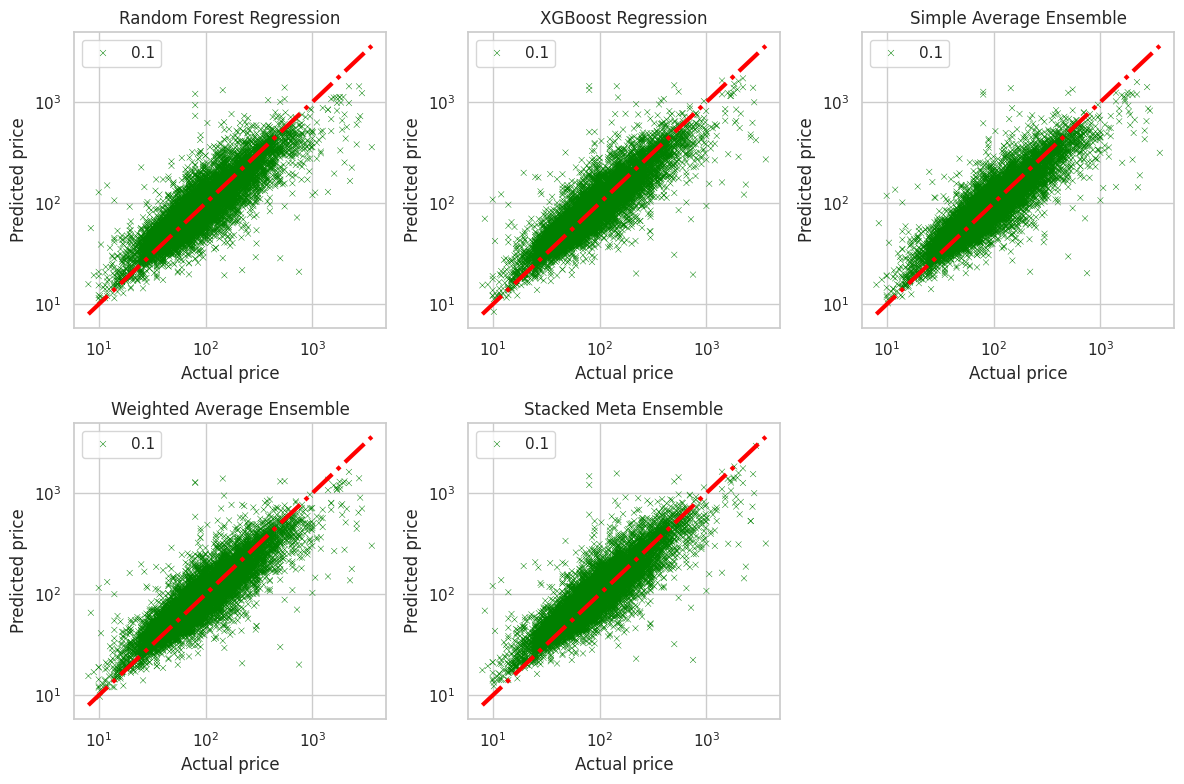

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(2, 3, 1)
sns.scatterplot(x=y_true, y=rfr_true, s=18, size=0.1, color='green', marker = 'x')
mn = min(y_true.min(), rfr_true.min())
mx = max(y_true.max(), rfr_true.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Random Forest Regression")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2, 3, 2)
sns.scatterplot(x=y_true, y=xgb_true, s=18, size=0.1, color='green', marker = 'x')
mn = min(y_true.min(), xgb_true.min())
mx = max(y_true.max(), xgb_true.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("XGBoost Regression")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2, 3, 3)
sns.scatterplot(x=y_true, y=avg_true, s=18, size=0.1, color='green', marker = 'x')
mn = min(y_true.min(), avg_true.min())
mx = max(y_true.max(), avg_true.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Simple Average Ensemble")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2, 3, 4)
sns.scatterplot(x=y_true, y=comb_wt, s=18, size=0.1, color='green', marker = 'x')
mn = min(y_true.min(), comb_wt.min())
mx = max(y_true.max(), comb_wt.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Weighted Average Ensemble")
plt.yscale('log')
plt.xscale('log')

plt.subplot(2, 3, 5)
sns.scatterplot(x=y_true, y=y_meta, s=18, size=0.1, color='green', marker = 'x')
mn = min(y_true.min(), y_meta.min())
mx = max(y_true.max(), y_meta.max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='-.', linewidth=3)
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.title("Stacked Meta Ensemble")
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(poly_meta_learner, "stacked_meta_regression.joblib")
joblib.dump(xgb, "xgb_regression.joblib")
joblib.dump(rf, "rf_regression.joblib")
files.download("stacked_meta_regression.joblib")
files.download("xgb_regression.joblib")
files.download("rf_regression.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(loc_map)
print(soc_map)

{'Electronic City Phase II': 1, 'Chikka Tirupathi': 2, 'Uttarahalli': 3, 'Lingadheeranahalli': 4, 'Kothanur': 5, 'Whitefield': 6, 'Old Airport Road': 7, 'Rajaji Nagar': 8, 'Marathahalli': 9, 'Gandhi Bazar': 10, '7th Phase JP Nagar': 11, 'Gottigere': 12, 'Sarjapur': 13, 'Mysore Road': 14, 'Bisuvanahalli': 15, 'Raja Rajeshwari Nagar': 16, 'Ramakrishnappa Layout': 17, 'Manayata Tech Park': 18, 'Kengeri': 19, 'Binny Pete': 20, 'Thanisandra': 21, 'Bellandur': 22, ' Thanisandra': 23, 'Mangammanapalya': 24, 'Electronic City': 25, 'Ramagondanahalli': 26, 'Yelahanka': 27, 'Hebbal': 28, 'Kasturi Nagar': 29, 'Kanakpura Road': 30, 'Electronics City Phase 1': 31, 'Kundalahalli': 32, 'Chikkalasandra': 33, 'Murugeshpalya': 34, 'Sarjapur  Road': 35, 'Ganga Nagar': 36, 'HSR Layout': 37, 'Doddathoguru': 38, 'KR Puram': 39, 'Himagiri Meadows': 40, 'Adarsh Nagar': 41, 'Bhoganhalli': 42, 'Lakshminarayana Pura': 43, 'Begur Road': 44, 'Devanahalli': 45, 'Govindaraja Nagar Ward': 46, 'Tharabanahalli': 47, 'Va